## Uncertainity in Deep Learning

Taken from http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html#uncertainty-sense

Also see: https://alexgkendall.com/computer_vision/bayesian_deep_learning_for_safe_ai/

In [1]:
%matplotlib inline

import numpy as np
import torch
from torch.autograd import Variable


from matplotlib import animation
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm, trange
from ipywidgets import interact, fixed

from sklearn.metrics import r2_score

from IPython.display import display, HTML

In [2]:
sns.set_context("poster")
sns.set_style("ticks")

np.random.seed(1337)

In [3]:
def get_data(N, min_x, max_x):
    w, b = np.random.rand(2)
    def true_model(X):
        y = np.sin(np.exp(w * X + b))
        return y
    X_true = np.linspace(min_x, max_x, N)
    y_true = true_model(X_true)
    span = (max_x - min_x)
    scale = 0.25
    X_obs = min_x + span*scale + np.random.rand(N)*(span - 2*scale*span)
    y_obs = true_model(X_obs) + np.random.randn(N)*0.2
    
    X_mean, X_std = X_obs.mean(), X_obs.std()
    y_mean, y_std = y_obs.mean(), y_obs.std()
    
    X_obs = (X_obs - X_mean)/ X_std
    X_true = (X_true - X_mean)/X_std
    
    y_obs = (y_obs - y_mean)/y_std
    y_true = (y_true - y_mean)/y_std
    
    return (X_obs, y_obs, X_true, y_true), (w, b, true_model)
    

In [4]:
N = 100
min_x, max_x = -20, 20
(X_obs, y_obs, X_true, y_true), (w, b, true_model) = get_data(N, min_x, max_x)

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


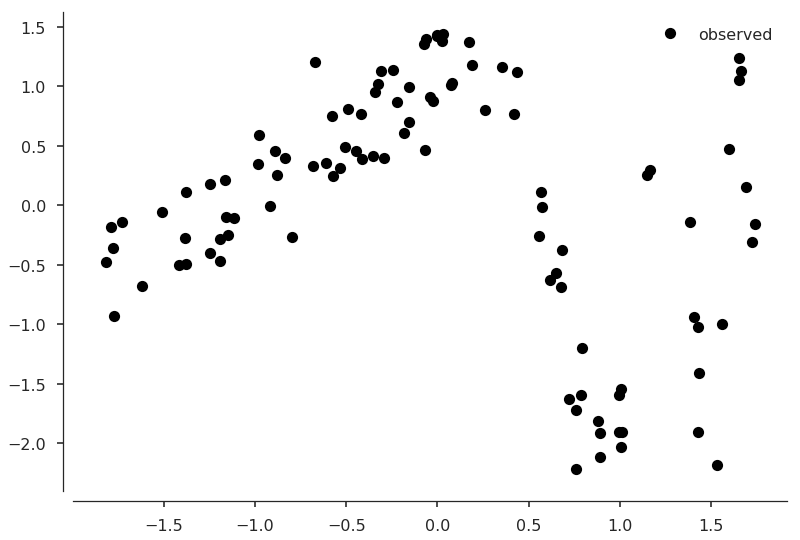

In [5]:
plt.plot(X_obs, y_obs, ls="none", marker="o", color="k", label="observed")
#plt.plot(X_true, y_true, ls="-", color="r", label="true", alpha=0.5)
plt.legend()
sns.despine(offset=10)

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


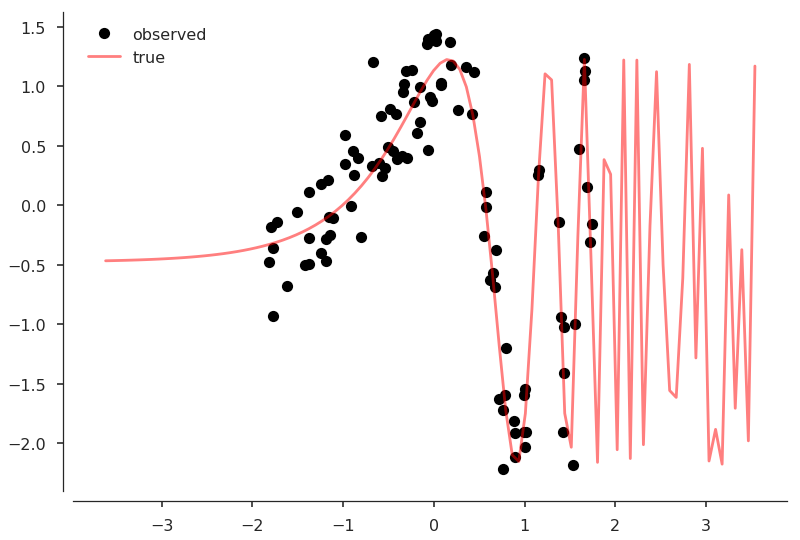

In [6]:
plt.plot(X_obs, y_obs, ls="none", marker="o", color="k", label="observed")
plt.plot(X_true, y_true, ls="-", color="r", label="true", alpha=0.5)
plt.legend()
sns.despine(offset=10)

In [7]:
class SimpleModel(torch.nn.Module):
    def __init__(self, p=0.05, decay=0.001, non_linearity=torch.nn.ReLU):
        super(SimpleModel, self).__init__()
        self.dropout_p = p
        self.decay = decay
        self.f = torch.nn.Sequential(
            torch.nn.Linear(1,20),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20, 20),
            non_linearity(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20,1)
        )
    def forward(self, X):
        X = Variable(torch.Tensor(X), requires_grad=False)
        return self.f(X)

In [8]:
model = SimpleModel(p=0.1, decay = 1e-6, non_linearity=torch.nn.Sigmoid)

In [9]:
def uncertainity_estimate(X, model, iters, N, l2=0.005, range_fn=range):
    outputs = np.hstack([model(X[:, np.newaxis]).data.numpy() for i in range_fn(iters)])
    y_mean = outputs.mean(axis=1)
    y_variance = outputs.var(axis=1)
    tau = l2 * (1-model.dropout_p) / (2*N*model.decay)
    y_variance += (1/tau)
    y_std = np.sqrt(y_variance)
    return y_mean, y_std

In [10]:
y_mean, y_std = uncertainity_estimate(X_true, model, 200, N=1)

In [11]:
def plot_model(model, selected_idx, iters=200, l2=1, n_std=3, ax=None):
    if ax is None:
        plt.close("all")
        plt.clf()
        fig, ax = plt.subplots(1,1)
        
    N = (selected_idx * 1).sum()
    y_mean, y_std = uncertainity_estimate(X_true, model, N=N, iters=iters, l2=l2)
    
    ax.plot(X_true, y_true, ls="-", color="0.1", label="true", alpha=0.5)
    ax.plot(X_true, y_mean, ls="-", color="b", label="mean")
    for i in range(n_std):
        ax.fill_between(
            X_true,
            y_mean - y_std * ((i+1)/2),
            y_mean + y_std * ((i+1)/2),
            color="b",
            alpha=0.1
        )
        
    y_mean, y_std = uncertainity_estimate(X_obs, model, N=N, iters=iters, l2=l2)
    next_idx = y_std[~selected_idx].argmax()
    next_idx = np.where(~selected_idx)[0][next_idx]
    
    R_score = r2_score(y_obs, y_mean)
    ax.set_title("R2={:.3f}, N={}, Next={}".format(R_score, N, next_idx))
    
    ax.plot(
        X_obs[~selected_idx],
        y_obs[~selected_idx],
        ls="none", marker="o",
        color="0.5", alpha=0.5,
        label="observed")
    ax.plot(
        X_obs[selected_idx],
        y_obs[selected_idx],
        ls="none", marker="*",
        color="purple", alpha=0.5,
        label="selected")
    
    ax.plot(
        X_obs[next_idx],
        y_obs[next_idx],
        ls="none", marker="*",
        color="r", alpha=0.5,
        ms=30,
        label="next")
    
    ax.legend()
    sns.despine(offset=10)
    selected_idx[next_idx] = True
    return ax, selected_idx, next_idx

/home/napsternxg/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars


/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


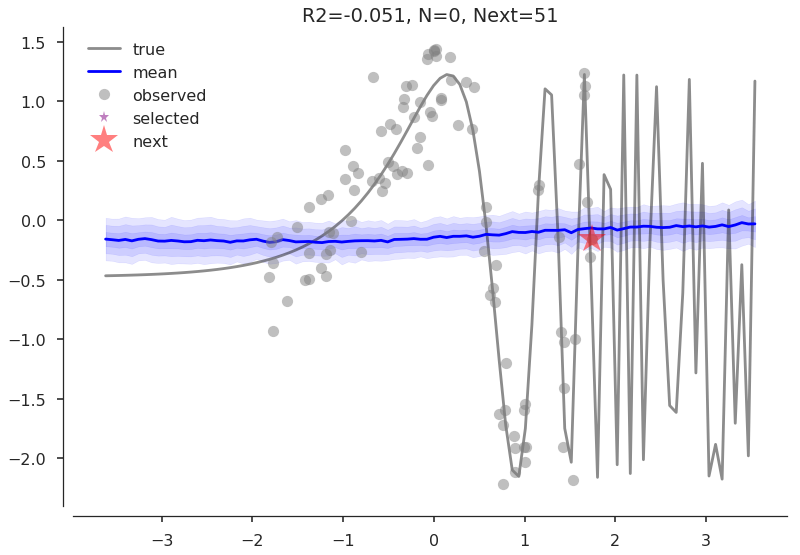

In [12]:
selected_idx = np.full_like(X_obs, False, dtype=np.bool)
ax, selected_idx, next_idx = plot_model(model, selected_idx, n_std=3, l2=0.01)

In [13]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.001, momentum=0.9,
    weight_decay=model.decay)

def fit_model(model, selected_idx, optimizer):
    y = Variable(
        torch.Tensor(
            y_obs[selected_idx, np.newaxis]),
        requires_grad=False
    )
    y_pred = model(X_obs[selected_idx, np.newaxis])
    optimizer.zero_grad()
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss

100%|██████████| 1000/1000 [00:00<00:00, 1156.69it/s]
/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


loss=Variable containing:
1.00000e-02 *
  1.1643
[torch.FloatTensor of size 1]



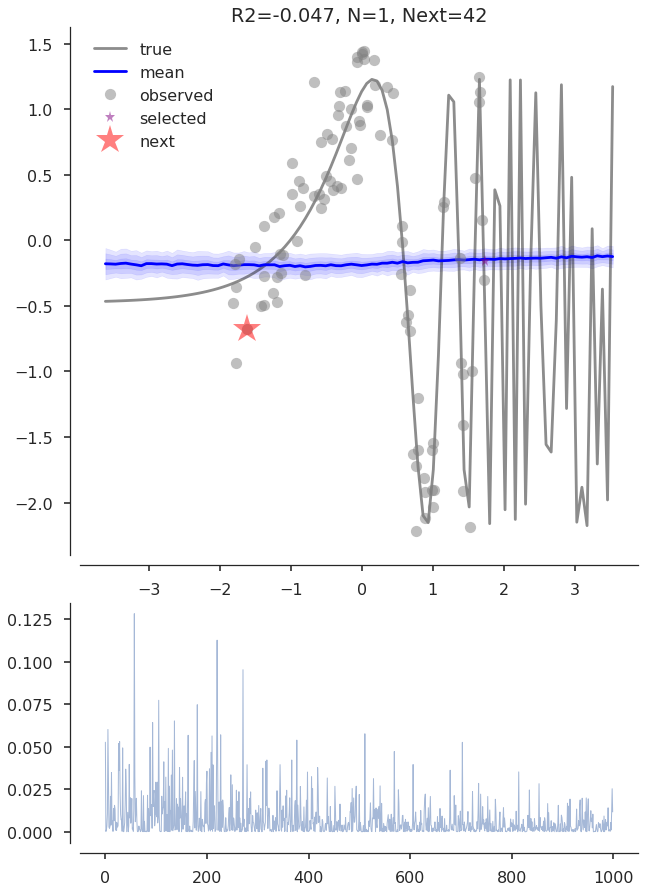

In [14]:
fig = plt.figure(figsize=(10, 15))
ax0 = plt.subplot2grid((3,1), (0, 0), rowspan=2)
ax1 = plt.subplot2grid((3,1), (2, 0))
losses = []
for i in trange(1000):
    loss = fit_model(model, selected_idx, optimizer)
    losses.append(loss.data.numpy()[0])
print("loss={}".format(loss))
ax1.plot(losses, ls="-", lw=1, alpha=0.5)
ax0, selected_idx, next_idx = plot_model(model, selected_idx, ax=ax0, l2=1)

## Animated training

In [15]:
class AnimateTraining(object):
    def __init__(self, model, u_iters=200, l2=1, n_std=4, title=""):
        self.model = model
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(
            model.parameters(),
            weight_decay=model.decay)
        
        self.losses = []
        self.n_std = n_std
        self.u_iters = u_iters
        self.l2 = l2
        self.title = title
        
        self.selected_idx = np.full_like(X_obs, False, dtype=np.bool)
        self.selected_idx[np.random.randint(X_obs.shape[0])] = True

        
        ## plot items
        self.fig, self.ax0 = plt.subplots(1,1)        
        
        self.pts_obs,  = self.ax0.plot(
            [], [],
            ls="none", marker="o",
            color="0.1", alpha=0.5, label="observed"
        )
        
        self.pts_selected, = self.ax0.plot(
            [], [],
            ls="none", marker="*",
            color="purple", alpha=0.5,
            label="selected"
        )
        
        self.pts_next, = self.ax0.plot(
            [], [],
            ls="none", marker="*",
            color="r", alpha=0.5,
            ms=30,
            label="next"
        )
        
        self.ax0.plot(X_true, y_true, ls="-", color="0.1", label="true")
        self.ln_mean, = self.ax0.plot([], [], ls="-", color="b", label="mean")
        
        self.loss_text = self.ax0.set_title('', fontsize=15)
        
        self.fill_stds = []
        for i in range(self.n_std):
            fill_t = self.ax0.fill_between(
                [], [], [],
                color="b",
                alpha=0.5**(i+1)
            )
            self.fill_stds.append(fill_t)
            
        self.ax0.legend(loc="upper left")
        
        
    def query_next(self):
        N = (selected_idx * 1).sum()
        y_mean, y_std = uncertainity_estimate(
            X_obs, self.model, N=N, iters=self.u_iters, l2=self.l2)
        next_idx = y_std[~self.selected_idx].argmax()
        next_idx = np.where(~self.selected_idx)[0][next_idx]
        return next_idx
        
    def fit_model(self):
        y = Variable(
            torch.Tensor(
                y_obs[self.selected_idx, np.newaxis]),
            requires_grad=False
        )
        y_pred = self.model(X_obs[self.selected_idx, np.newaxis])
        self.optimizer.zero_grad()
        loss = self.criterion(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return loss
            
    def init_plot(self):
        self.ln_mean.set_data([], [])
        self.loss_text.set_text('')
        return self.ln_mean, self.loss_text
    
    def animate_plot(self, i):
        for j in range(100):
            loss = self.fit_model().data.numpy()[0]
            self.losses.append(loss)
        
        
        N = (self.selected_idx*1).sum()

        y_mean, y_std = uncertainity_estimate(
            X_true, self.model, self.u_iters,
            N=N,
            l2=self.l2,
            range_fn=range
        )
        
        self.ln_mean.set_data(X_true, y_mean)
        for std_i in range(self.n_std):
            self.fill_stds[std_i].remove()
            self.fill_stds[std_i] = self.ax0.fill_between(
                X_true,
                y_mean - y_std * ((std_i+1)/2),
                y_mean + y_std * ((std_i+1)/2),
                color="b",
                alpha=0.1
            )
        
        R_score = r2_score(y_obs, y_mean)
        next_idx = None
        if N < X_obs.shape[0]:
            next_idx = self.query_next()
            self.pts_obs.set_data(
                X_obs[~self.selected_idx],
                y_obs[~self.selected_idx]
            )
            
            self.pts_next.set_data(
                X_obs[next_idx],
                y_obs[next_idx],
            )
        
        self.loss_text.set_text("{}, loss[{}]={:.3f}, R2={:.3f}, N={}, Next={}".format(
            self.title, (i+1)*100, loss, R_score, N, next_idx))
        
        
        self.pts_selected.set_data(
            X_obs[self.selected_idx],
            y_obs[self.selected_idx],
        )
        
        if next_idx:
            self.selected_idx[next_idx] = True
        
        return ([
            self.ln_mean,
            self.pts_obs,
            self.pts_selected,
            self.pts_next,
            self.loss_text
        ] + self.fill_stds)
        
        
    def train(self, iters, interval=100):
        anim = animation.FuncAnimation(
            self.fig, self.animate_plot, init_func=self.init_plot,
            frames=range(iters), interval=interval, blit=True)
        return HTML(anim.to_html5_video())


/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


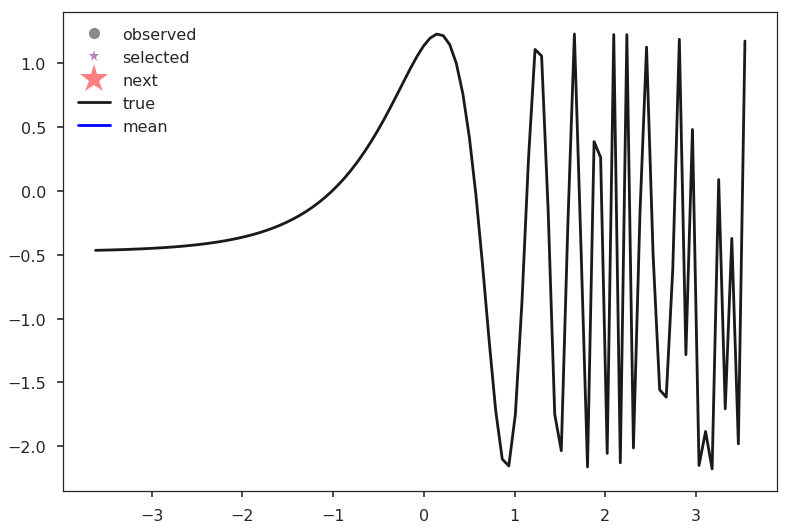

In [16]:
model = SimpleModel(p=0.1, decay = 1e-6, non_linearity=torch.nn.Sigmoid)
animate_obj = AnimateTraining(model, l2=0.01, title="Simple")

In [17]:
animate_obj.train(150, interval=150)

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


## Multiple non-linearities

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


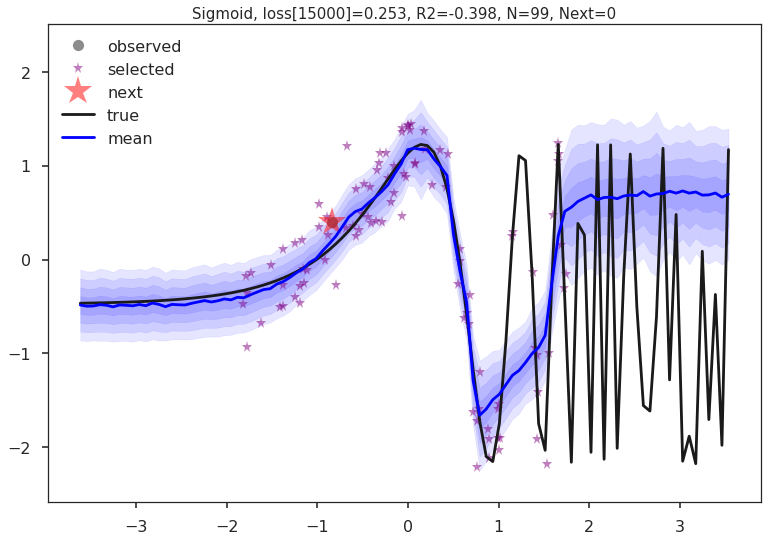

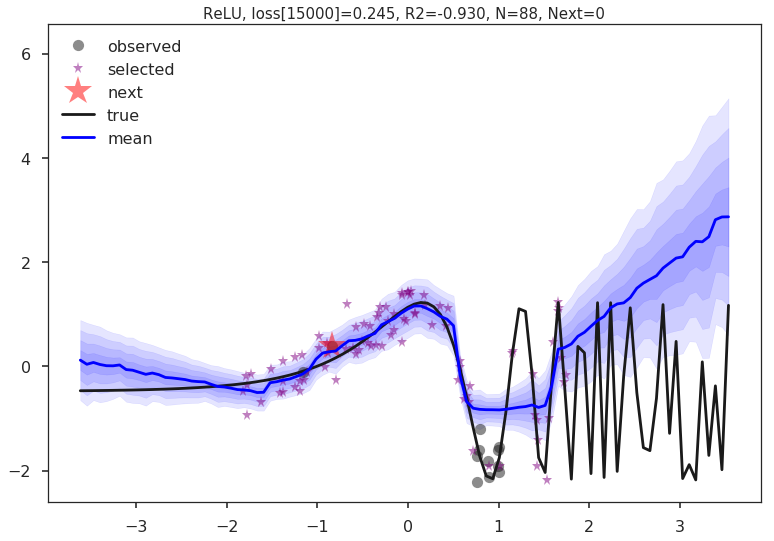

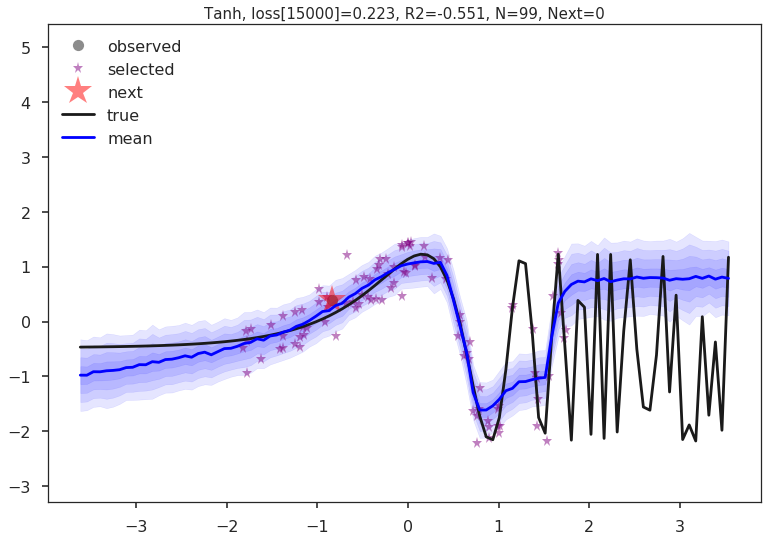

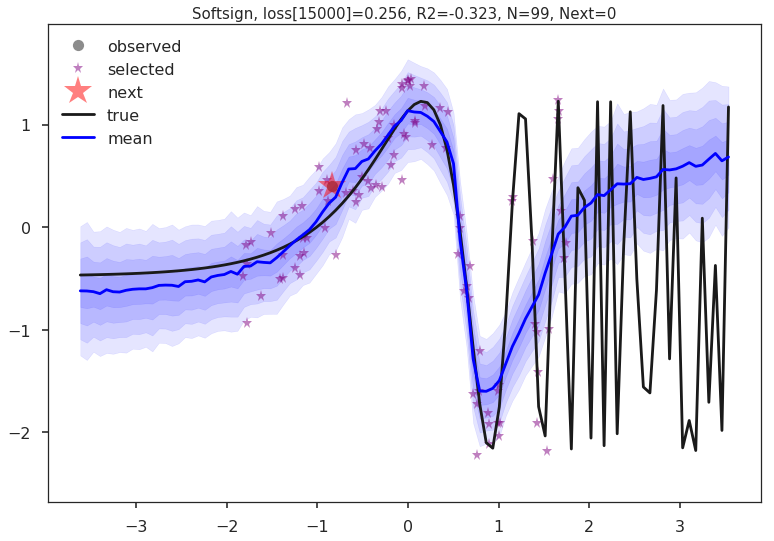

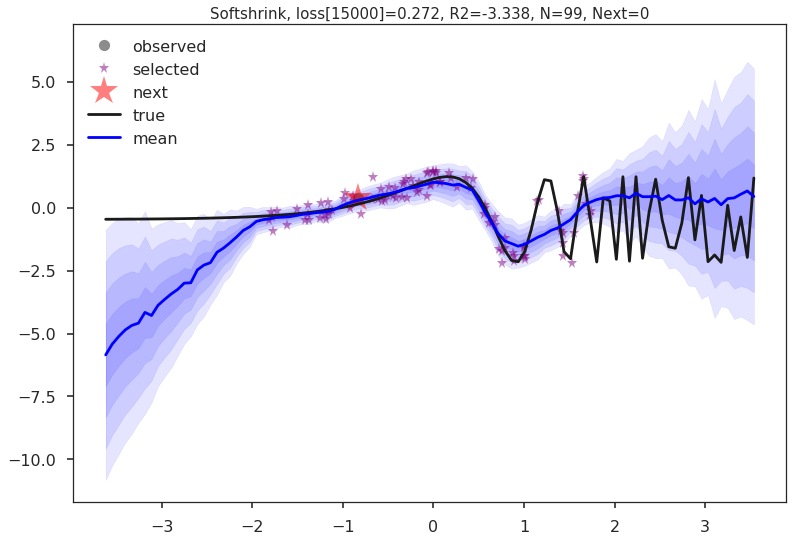

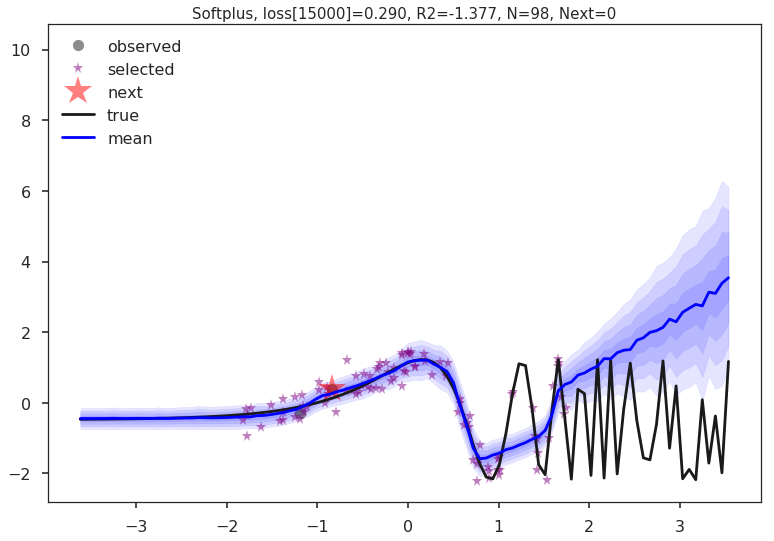

In [18]:
for i, (non_linearity, title) in enumerate([
    (torch.nn.Sigmoid, "Sigmoid"),
    (torch.nn.ReLU, "ReLU"),
    (torch.nn.Tanh, "Tanh"),
    (torch.nn.Softsign, "Softsign"),
    (torch.nn.Softshrink, "Softshrink"),
    (torch.nn.Softplus, "Softplus")
]):
    display(HTML("<h1>{}</h1>".format(title)))
    model = SimpleModel(p=0.1, decay = 1e-6, non_linearity=non_linearity)
    animate_obj = AnimateTraining(model, l2=0.01, title=title)
    display(animate_obj.train(150, interval=150))